In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 29 21:06:30 2022
Modified on Mon Sept 9 by awb9691
@author: ssb60
@author: Abigail Broscius awb9691@rit.edu
"""
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.callbacks import History
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import tensorflow as tf
import torch
from torch import nn
from torch.autograd import Variable
from pathlib import Path
import os

In [2]:
# Check for GPU architecture/compat
print("CUDA version:", torch.version.cuda)
print("GPU available? (pytorch):", torch.cuda.is_available())


CUDA version: 11.8
GPU available? (pytorch): False


In [43]:
# Load in data
Time_series_X_train = torch.tensor(np.load(r'T_s_X_train.npy')[0:100], dtype=torch.float32)
Time_series_Y_train = torch.tensor(np.load(r'T_s_Y_train_flattened.npy')[0:100], dtype=torch.float32)
Time_series_X_test = torch.tensor(np.load(r'T_s_X_test.npy'), dtype=torch.float32)
Time_series_Y_test = torch.tensor(np.load(r'T_s_Y_test_flattened.npy'), dtype=torch.float32)

In [4]:
# Check data shape
print("x train shape:")
print(Time_series_X_train.shape)
print("y train shape:")
print(Time_series_Y_train.shape)


x train shape:
torch.Size([100, 192, 120])
y train shape:
torch.Size([100, 2880])


In [5]:
# Create File System for saving output

# Parent Directories
parent_dir = r".\Outputs_from_models"
directory = "path_testing"  # change
path = os.path.join(parent_dir, directory)
Path(path).mkdir(parents=True, exist_ok=True)
print("Directory '% s' created" % directory)


Directory 'path_testing' created


In [6]:
# Leaf directories
pathT = path + "\\Testing_data"
Path(pathT).mkdir(parents=True, exist_ok=True)
pathM = path + "\\Model"
Path(pathM).mkdir(parents=True, exist_ok=True)
pathP = path + "\\Plots"
Path(pathP).mkdir(parents=True, exist_ok=True)

In [7]:
# Create a class for model structure in torch
class TorchModel(nn.Module):
    def __init__(self, seq_len, input_size, num_layers):
        super(TorchModel, self).__init__()
        self.input_size = input_size
        self.seq_length = seq_len
        self.num_layers = num_layers

        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=1000, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=1000, hidden_size=500, batch_first=True)
        self.fc_1 = nn.Linear(500, 3000)
        self.fc_2 = nn.Linear(3000, 1000)
        self.fc_3 = nn.Linear(1000, 3000)
        self.op_layer = nn.Linear(3000, 2880)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print("input shape:", x.shape)
        h_0 = Variable(torch.zeros(self.num_layers, x.shape[0], 1000))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.shape[0], 1000))  # internal state
        h_1 = Variable(torch.zeros(self.num_layers, x.shape[0], 500))  # hidden state
        c_1 = Variable(torch.zeros(self.num_layers, x.shape[0], 500))# internal state
        # print("h0 shape:", h_0.shape)
        # print("c0 shape:", c_0.shape)
        # print("h1 shape:", h_1.shape)
        # print("c1 shape:", c_1.shape)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))  # first lstm layer
        output = self.sigmoid(output)
        # print("LSTM1 output shape:", output.shape)
        # hn = hn.view(-1, 500)
        out, (hn, cn) = self.lstm_2(output, (h_1, c_1))  # second lstm layer
        out = self.tanh(out)
        hn = hn.view(-1, 500)
        out = self.relu(hn)
        out = self.fc_1(out)  # first fc layer
        # print("out shape 1FC:", out.shape)
        out = self.relu(out)
        out = self.fc_2(out)  # second fc layer
        # print("out shape 2FC:", out.shape)
        out = self.relu(out)
        out = self.fc_3(out)  # third fc layer
        # print("out shape 3FC:", out.shape)
        out = self.relu(out)
        out = self.op_layer(out)  # O/P layer
        # print("out shape OP:", out.shape)
        out = self.sigmoid(out)

        return out


In [8]:
# Define model hyperparameters
seq_len = Time_series_X_train.shape[1]  # number of timestamps in 1 sample
input_size = Time_series_X_train.shape[2]  # number of features in 1 sample
# 1 sample = num timestamps x num features(power lines)
num_epochs = 4
learning_rate = 0.001

In [9]:
# Instantiate the model
torchmodel = TorchModel(input_size=input_size, seq_len=seq_len, num_layers=1)
print(torchmodel)

TorchModel(
  (lstm_1): LSTM(120, 1000, batch_first=True)
  (lstm_2): LSTM(1000, 500, batch_first=True)
  (fc_1): Linear(in_features=500, out_features=3000, bias=True)
  (fc_2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc_3): Linear(in_features=1000, out_features=3000, bias=True)
  (op_layer): Linear(in_features=3000, out_features=2880, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)


In [10]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()  # mean squared error
optimizer = torch.optim.Adam(torchmodel.parameters(),
                             lr=learning_rate,
                             betas=(0.9,0.99),
                             eps=1e-07,
                             )


In [44]:
# Training!!
train_loss_hist = []
test_loss_hist = []
predictions = 0
for epoch in range(num_epochs):
    # Train on the Training Set:
    torchmodel.train()
    outputs = torchmodel.forward(Time_series_X_train)  # forward pass
    optimizer.zero_grad()  # calculate the gradient

    # Loss Function
    loss = criterion(outputs, Time_series_Y_train)
    loss.backward()
    train_loss_hist.append(loss.item())  # track loss history
    optimizer.step()  # backpropagation

    # Evaluate on the Test Set:
    torchmodel.eval()
    with torch.no_grad():
        pred = torchmodel(Time_series_X_test)
        test_loss = criterion(pred, Time_series_Y_test).item()
        test_loss_hist.append(test_loss)
        if (epoch + 1) == num_epochs:  # on last training epoch
            # save testing predictions
            print("FINAL EPOCH")
            predictions = pred
            

    print("Epoch: %d, Train loss: %1.5f" % (epoch, loss.item()))
    print("\t Test loss: %1.5f" % test_loss)


Epoch: 0, Train loss: 0.02135
	 Test loss: 0.02360
Epoch: 1, Train loss: 0.01970
	 Test loss: 0.02148
Epoch: 2, Train loss: 0.01799
	 Test loss: 0.02167
FINAL EPOCH
Epoch: 3, Train loss: 0.01867
	 Test loss: 0.02298


In [13]:
print(train_loss_hist)

[0.08412639796733856, 0.07724989950656891, 0.035829879343509674, 0.05915457382798195]


In [45]:
print(predictions)

tensor([[0.1199, 0.2458, 0.4358,  ..., 0.3518, 0.3674, 0.3080],
        [0.1199, 0.2458, 0.4358,  ..., 0.3518, 0.3674, 0.3080],
        [0.1199, 0.2458, 0.4358,  ..., 0.3518, 0.3674, 0.3080],
        ...,
        [0.1199, 0.2458, 0.4358,  ..., 0.3518, 0.3674, 0.3080],
        [0.1200, 0.2458, 0.4358,  ..., 0.3518, 0.3674, 0.3080],
        [0.1200, 0.2458, 0.4358,  ..., 0.3519, 0.3674, 0.3080]])


.\Outputs_from_models\path_testing\Plots\loss.png


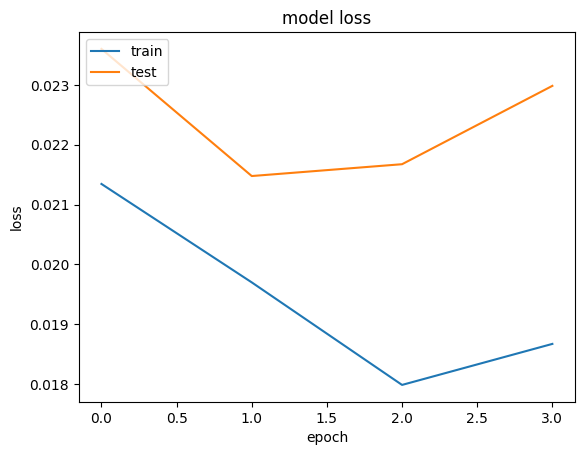

In [46]:
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(path+r'\Plots'+r'\loss.png')
print(path+r'\Plots'+r'\loss.png')
plt.show()

In [47]:
predictions[predictions<=0.3333] = 0
predictions[predictions > 0.3333]=1
pred = predictions
idx_y=np.load('y_test_idx.npy')
print(idx_y)
# [0:100]
df=pd.DataFrame(pred)
df.insert(loc=0,column='day',value=idx_y[:,0])
#df.insert(loc=1,column='hour',value=idx_y[:,1])
#df['hour']=idx_y[:,1]

[[  56. 1321.]
 [  56. 1322.]
 [  56. 1323.]
 ...
 [ 323. 7750.]
 [ 323. 7751.]
 [ 323. 7752.]]


In [24]:
mask1 = df.duplicated(subset=['day'],keep = "first") # this line is to get the first occ.
df2=df[~mask1]

pred_0_hr =df2.to_numpy()


In [25]:
pred_0_hr_list =[]
temp=[]
counter_op=0
for i in range (1,len(pred_0_hr)):
    if ( pred_0_hr[i,0]-pred_0_hr[i-1,0])<2:
        temp.append(pred_0_hr[i,:])
        if i== len(pred_0_hr)-1:
            temp_np=np.array(temp)
            index_for_temp=2
            new_temp_1=[]
            for count_reshape_r in range (0,len(temp_np)):
                new_temp=[]
                new_temp.append(temp_np[count_reshape_r,0])
                    
                for count_reshape_c in range (1,temp_np.shape[1]):
                    if ((count_reshape_c) % 120)==0 : 
                        new_temp.append(temp_np[count_reshape_r,count_reshape_c])
                        new_temp_1.append(new_temp)
                        new_temp=[]
                        new_temp.append(temp_np[count_reshape_r,0])
                        
                    else: 
                        new_temp.append(temp_np[count_reshape_r,count_reshape_c])

                           
            new_temp_1=np.array(new_temp_1)
            df_3=pd.DataFrame(new_temp_1)
            file_name=path +r'\Testing_data\excel'+str(counter_op)+'.xlsx'
            df_3.to_excel(file_name)
    else:
        temp_np=np.array(temp)
        index_for_temp=2
        new_temp_1=[]
        for count_reshape_r in range (0,len(temp_np)):
            new_temp=[]
            new_temp.append(temp_np[count_reshape_r,0])
                
            for count_reshape_c in range (1,temp_np.shape[1]):
                if ((count_reshape_c ) % 120)==0 : 
                    new_temp.append(temp_np[count_reshape_r,count_reshape_c])
                    new_temp_1.append(new_temp)
                    new_temp=[]
                    new_temp.append(temp_np[count_reshape_r,0])
                    
                else: 
                    new_temp.append(temp_np[count_reshape_r,count_reshape_c])
                    
       
        new_temp_1=np.array(new_temp_1)
        df_3=pd.DataFrame(new_temp_1)
        file_name=path+r'\Testing_data\excel'+str(counter_op)+'.xlsx'
        df_3.to_excel(file_name)
        temp=[]
        counter_op=counter_op+1
        


In [26]:
#df.to_excel('out_33_10_xy_y_56.xlsx')
np.save(path +r'\output.npy',pred)


In [27]:
pred_t=pred
np.save(path +r'\output.npy',pred_t)

In [34]:
Time_series_Y_test[Time_series_Y_test<=0.33]=0
Time_series_Y_test[Time_series_Y_test > 0.33]=1
print(torch.numel(Time_series_Y_test))
tp = np.count_nonzero(Time_series_Y_test == 1)
tn = np.count_nonzero(Time_series_Y_test == 0)
pp = np.count_nonzero(pred == 1)
pn =np.count_nonzero(pred == 0)

print('trueval_pos')
print(tp)
print('trueval_neg')
print(tn)
print('positive_pred')
print(pp)
print('negative_pred')
print(pn)


288000
trueval_pos
141241
trueval_neg
146759
positive_pred
131600
negative_pred
156400


In [38]:
total_positive=np.count_nonzero(Time_series_Y_test == 1)
total_negative =np.count_nonzero(Time_series_Y_test == 0)
pred_pos=np.count_nonzero(pred_t == 1)
pred_neg =np.count_nonzero(pred_t == 0)

mat_1 = Time_series_Y_test + pred_t
tp = np.count_nonzero(mat_1 == 2)
tp_arr=np.count_nonzero(mat_1 == 2,0)
tn=np.count_nonzero(mat_1 == 0)
tn_arr=np.count_nonzero(mat_1 == 0,0)

mat_2 = Time_series_Y_test - pred_t
fn = np.count_nonzero(mat_2 == 1)
fn_arr=np.count_nonzero(mat_2 == 1,0)
fp =np.count_nonzero(mat_2 ==-1)
fp_arr=np.count_nonzero(mat_2 == -1,0)

In [39]:
df_cm=pd.DataFrame(tp_arr.T)
#df. rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}, inplace = True)
df_cm.rename(columns={0:'True_Positive'},inplace='True')
df_cm.insert(loc=1,column='True_Negative',value=tn_arr)
df_cm.insert(loc=2,column='False_Positive',value=fp_arr)
df_cm.insert(loc=3,column='False_Negative',value=fn_arr)
lines =np.linspace(1, 120, num=120)
lines_arr = np.tile(lines,24)
df_cm.insert(loc=0,column='Line_No',value=lines_arr)
hour=np.linspace(1, 24, num=24)
hour_arr = np.repeat(hour,120)
df_cm.insert(loc=1,column='Hour',value=hour_arr)
file_name=path+'\confusion_matrix.xlsx'
df_cm.to_excel(file_name)
df_false_neg = df_cm.groupby(["Line_No"]).False_Negative.sum().reset_index()

<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Abby\AppData\Local\Temp\ipykernel_17392\3221100961.py:13: SyntaxWarning: invalid escape sequence '\c'
  file_name=path+'\confusion_matrix.xlsx'


In [40]:
print('tp')
print(tp)
print('tn')
print(tn)
print('fp')
print(fp)
print('fn')
print(fn)

f1_score = 2*tp/(2*tp + fp + fn)
print('F1-score = ',f1_score)

print('Most false neg line')
print(df_false_neg.loc[df_false_neg.False_Negative.idxmax(),'False_Negative'])
print("No of times")
print(df_false_neg.loc[df_false_neg.False_Negative.idxmax(),'Line_No'])

tp
109255
tn
124414
fp
22345
fn
31986
F1-score =  0.8008693708057073
Most false neg line
1960
No of times
88.0


In [ ]:
LSTM_model.evaluate(Time_series_X_test,Time_series_Y_test)
LSTM_model.evaluate(Time_series_X_train,Time_series_Y_train)


In [ ]:
# saving model 
LSTM_model.save(path+'\Model'+'\LSTM_model.h5')
np.save(path+'\Model'+'\my_history_LSTM_model.npy',history.history,allow_pickle=True)


[0.53042661 0.67506733 0.5795726  ... 0.65828571 0.86439543 0.65578037]


<>:8: SyntaxWarning: invalid escape sequence '\F'
<>:15: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\H'
<>:22: SyntaxWarning: invalid escape sequence '\H'
<>:8: SyntaxWarning: invalid escape sequence '\F'
<>:15: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\H'
<>:22: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Abby\AppData\Local\Temp\ipykernel_17392\3526184465.py:8: SyntaxWarning: invalid escape sequence '\F'
  np.save(path+'\False_Negative.npy',fn_per)
C:\Users\Abby\AppData\Local\Temp\ipykernel_17392\3526184465.py:15: SyntaxWarning: invalid escape sequence '\F'
  np.save(path+'\False_Positive.npy',fp_per)
C:\Users\Abby\AppData\Local\Temp\ipykernel_17392\3526184465.py:17: SyntaxWarning: invalid escape sequence '\H'
  plt.savefig(path+r'\Plots'+'\Histogram_False_Positive.png')
C:\Users\Abby\AppData\Local\Temp\ipykernel_17392\3526184465.py:22: SyntaxWarning: invalid escape sequence '\H'

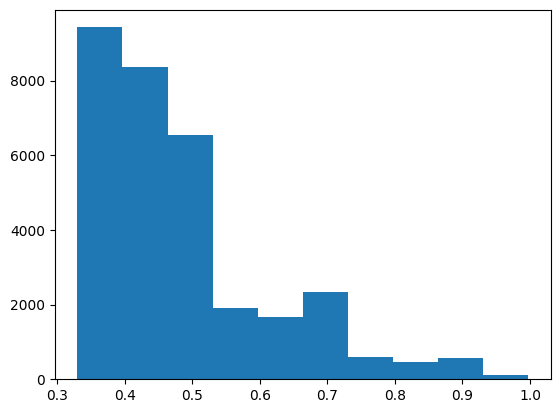

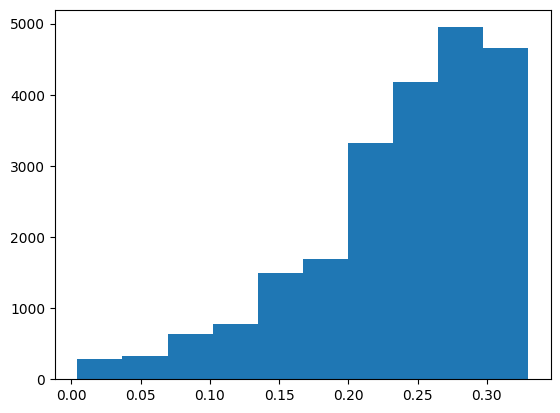

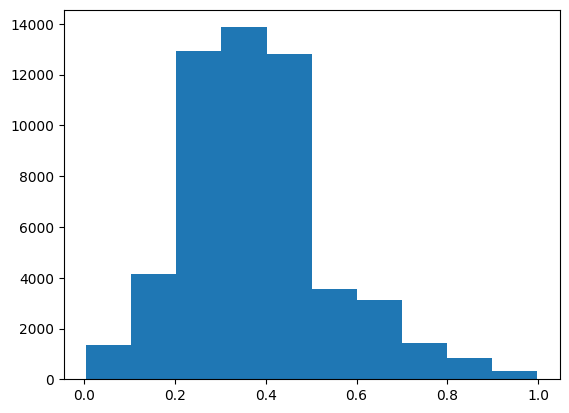

In [41]:
Y_percentage_test = np.load('T_s_Y_test_flattened.npy')
    
indices = np.where(mat_2 == 1)

print(Y_percentage_test[indices])
fn_per=Y_percentage_test[indices]

np.save(path+'\False_Negative.npy',fn_per)
plt.hist(fn_per)
plt.savefig(path+r'\Plots'+r'\Histogram_False_Negative.png')
plt.show() 
  
indices = np.where(mat_2 == -1)
fp_per=Y_percentage_test[indices]
np.save(path+'\False_Positive.npy',fp_per)
plt.hist(fp_per)
plt.savefig(path+r'\Plots'+'\Histogram_False_Positive.png')
plt.show() 

Errors_true_false =np.append(fn_per,fp_per)
plt.hist(Errors_true_false)
plt.savefig(path+r'\Plots'+'\Histogram_Errors.png')
plt.show() 
